# Kaggle - Titanic

## Data analysis

- PassengerId

- Pclass: 1st, 2nd or 3rd class

- Sex

- Age

- SibSp: # of siblings / spouses

- Parch: # of parents / children

- Fare: ticket price.

- Cabin: cabin number.

- Embarked: port of embarcation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [1]:
import pprint
import pandas as pd
import numpy as np

data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
data['Survived'].groupby(data['Pclass']).describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,0.629630,0.484026,0.0,0.0,1.0,1.0,1.0
2,184.0,0.472826,0.500623,0.0,0.0,0.0,1.0,1.0
3,491.0,0.242363,0.428949,0.0,0.0,0.0,0.0,1.0


In [3]:
data['Survived'].groupby(data['Sex']).describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,314.0,0.742038,0.438211,0.0,0.0,1.0,1.0,1.0
male,577.0,0.188908,0.391775,0.0,0.0,0.0,0.0,1.0


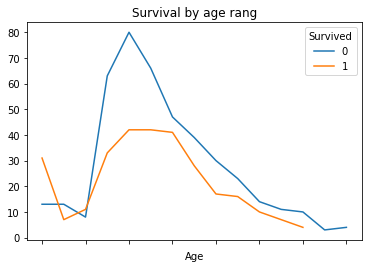

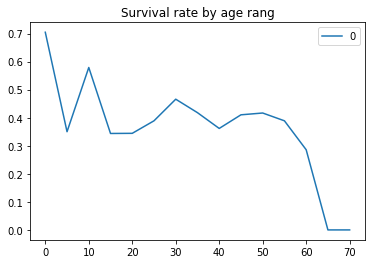

In [21]:
import itertools

age_bins = [x for x in range(0,80,5)]
cutted = pd.cut(data.Age, age_bins)
byage = data.groupby(['Survived', cutted]).size()
byage.unstack().T.plot(title='Survival by age rang')

survival_percentage = pd.DataFrame([x[1] / sum(x) for x in itertools.zip_longest(byage[0], byage[1], fillvalue=0)], age_bins[:-1])
survival_percentage.plot(title='Survival rate by age rang')

## Feature engineering

In [5]:
from sklearn.preprocessing import LabelEncoder


def find_title(full_string):
    titles = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']
    for title in titles:
        if(full_string.find(title) != -1):
            return title
    return np.nan

def replace_titles(row):
    title = row['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if row['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
def get_cabin_letter(cabin):
    if(cabin is not np.nan):
        return cabin[0]
    return 'Unknown'
    
def feature_engineering(data):
    X = data.copy()
    del X['Ticket']
    del X['Embarked']
    del X['PassengerId']
    del X['Fare']
    
    # we get the titles from the names
    X['Title'] = X['Name'].apply(find_title)
    X['Title'] = X.apply(replace_titles, axis=1)
    del X['Name']
    # we encode the titles
    le_title = LabelEncoder()
    le_title.fit(X.Title.unique())
    X['Title'] = le_title.transform(X['Title'])
    
    # we get a new feature: family members
    X['FamMemb'] = X.SibSp + X.Parch
    
    # we transform the cabin number to a simpler value: [A, B, C, D, E, F, G, T, 'Unknown']
    X['Cabin'] = X['Cabin'].apply(get_cabin_letter)
    # we encode the cabin number
    le_cabin = LabelEncoder()
    le_cabin.fit(sorted(X.Cabin.unique()))
    X['Cabin'] = le_cabin.transform(X['Cabin'])

    # we encode the sex labels with "One hot encoding"
    X['IsFemale'] = pd.get_dummies(X, columns=['Sex'])['Sex_female']
    X.drop('Sex', axis=1, inplace=True)
    
    return X

In [6]:
X = feature_engineering(data)
y = X['Survived']
del X['Survived']
X.head()

,Pclass,Age,SibSp,Parch,Cabin,Title,FamMemb,IsFemale
0,3,22.0,1,0,8,2,1,0
1,1,38.0,1,0,2,3,1,1
2,3,26.0,0,0,8,1,0,1
3,1,35.0,1,0,2,3,1,1
4,3,35.0,0,0,8,2,0,0


### What about 'NaN' in Age? Predicting age with Linear Regression

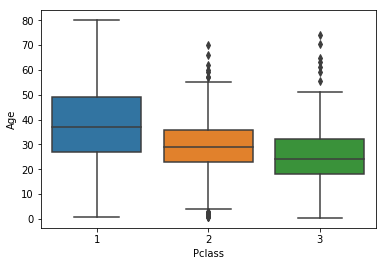

In [7]:
import seaborn as sns
sns.boxplot(x='Pclass', y='Age', data=X)

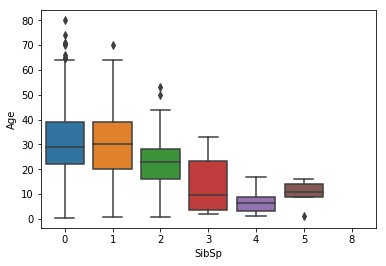

In [8]:
sns.boxplot(x='SibSp', y='Age', data=X)

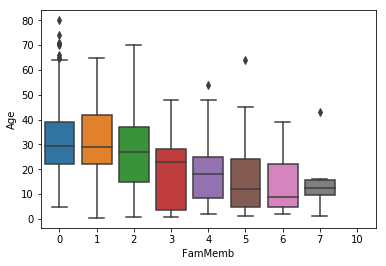

In [9]:
sns.boxplot(x='FamMemb', y='Age', data=X)

We train a linear regression model to predict age in function of the features PClass, SibSp and FamMemb, which we have already seen that correlate with age.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def get_age_features(data):
    return data[['SibSp', 'Pclass', 'FamMemb', 'IsFemale']]

# we will use the whole dataset to predict ages
X_test = feature_engineering(test_data)
X_whole = pd.concat([X, X_test], sort=False)
# we divide it
age_training = X_whole[X_whole.Age.notna()]
age_topredict = X_whole[X_whole.Age.isna()]

# we train our model
age_training_X = get_age_features(age_training)
age_training_Y = age_training.Age
age_model = LinearRegression()
age_model.fit(age_training_X, age_training_Y)

# we evaluate our model over the training set
mean_squared_error(age_training.Age, age_model.predict(age_training_X))


159.9558939662744

With our trained linear regression model, now we can predict the missing values for Age.

In [11]:
def fill_age_nan(model, data):
    if(data.Age.isna().any()):
        data.loc[data.Age.isna(), 'Age'] = model.predict(get_age_features(data.loc[data.Age.isna()]))
        data.Age = data.Age.apply(lambda x: 0 if x < 0 else x)

fill_age_nan(age_model, X)

## V1 - Multiple-Layer Perceptron Model

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

best_score = { 'Accuracy': 0 }
best_cls = None
for hu1 in range(3,10):
    for hu2 in range(1,5):
        for i in range(5): #random subsets
            # we separate it to two datasets: training (80), testing (20)
            trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2)

            # defining the model to train
            cls = MLPClassifier(hidden_layer_sizes=(hu1, hu2), activation='logistic', max_iter=2000)

            # we train it with our training set
            cls.fit(trainX, trainY)

            # We evaluate the model over our testset
            predictedY = cls.predict(testX)
            score = accuracy_score(testY, predictedY)
            if(score > best_score['Accuracy']):
                best_cls = cls
                best_score = { 'Accuracy': accuracy_score(testY, predictedY), 
                              'HiddenUnits' : (hu1, hu2) }

print(best_score)
classifier_MLP = best_cls

{'Accuracy': 0.88268156424581, 'HiddenUnits': (9, 1)}


## V2 - Random Forest Model

In [35]:
from sklearn.tree import DecisionTreeClassifier

best_score = { 'Accuracy': 0 }
best_cls = None
for i in range(100): #random subsets
    # we separate it to two datasets: training (80), testing (20)
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2)

    # defining the model to train
    cls = DecisionTreeClassifier()

    # we train it with our training set
    cls.fit(trainX, trainY)

    # We evaluate the model over our testset
    predictedY = cls.predict(testX)
    score = accuracy_score(testY, predictedY)
    if(score > best_score['Accuracy']):
        best_cls = cls
        best_score = { 'Accuracy': accuracy_score(testY, predictedY)}
                
print(best_score)
classifier_DT = best_cls

{'Accuracy': 0.8547486033519553}


# Submission

In [38]:
# Once we got our model trained, we can use it to predict the results for the whole test dataset

def create_submission(classifier):
    fill_age_nan(age_model, X_test)

    predictions = classifier.predict(X_test)

    submission_dataframe = pd.DataFrame(columns=['PassengerId', 'Survived'])
    submission_dataframe['PassengerId'] = test_data.PassengerId
    submission_dataframe['Survived'] = predictions

    submission_dataframe.to_csv('submission_210119_v1.csv', index=False)
    
    return submission_dataframe


In [39]:
submission = create_submission(classifier_DT)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1
